Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


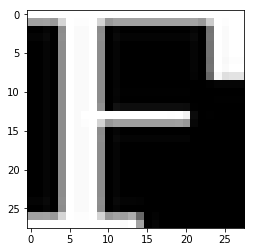

[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('data/', one_hot=True)
(train_data, validation_data, test_data) = (mnist.train, mnist.validation, mnist.test)
i = 1500
plt.imshow(train_data.images[i].reshape((28, 28)), cmap='gray')
plt.show()
print(train_data.labels[i])

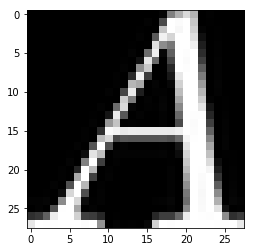

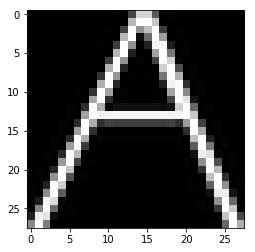

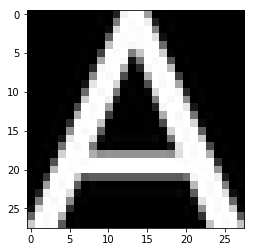

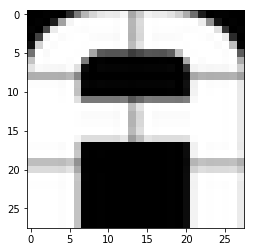

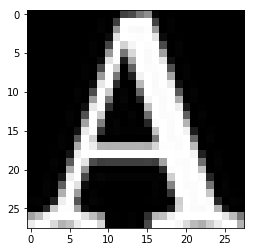

In [2]:
A_indices = [ ind for ind in range(train_data.num_examples) if train_data.labels[ind][0] == 1  ]
for ind in A_indices[:5]:
    plt.imshow(train_data.images[ind].reshape((28, 28)), cmap='gray')
    plt.show()

In [3]:
with tf.name_scope('Inputs') as scope:
    x = tf.placeholder(shape=[None, 784], dtype=tf.float32, name='images')
    x_image = tf.reshape(x, [-1, 28, 28, 1], name='2d_images')
    y_correct = tf.placeholder(shape=[None, 10], dtype=tf.float32, name='correct_output')

# first convolution
filter_conv1 = 32
#W_conv1 = tf.Variable(tf.truncated_normal(shape=[6, 6, 1, filter_conv1], stddev=0.1), name="W_conv1")
W_conv1 = tf.Variable(tf.truncated_normal(shape=[6, 6, 1, filter_conv1], stddev=0.1), name="W_conv1")
b_conv1 = tf.Variable(tf.zeros([filter_conv1]), name="b_conv1")
h_conv1 = tf.nn.conv2d(x_image, W_conv1, strides=[1, 2, 2, 1], padding='SAME') + b_conv1   # (None, 14, 14, filter_conv1)
h_conv1_relu = tf.nn.relu(h_conv1)

#with tf.name_scope('First_pooling') as scope:
h_pool_1 = tf.nn.max_pool(h_conv1_relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')  # (None, 7, 7, filter_conv1)

# second convolution
filter_conv2 = 64
#W_conv2 = tf.Variable(tf.truncated_normal(shape=[4, 4, filter_conv1, filter_conv2], stddev=0.1), name="W_conv2")
W_conv2 = tf.Variable(tf.truncated_normal(shape=[5, 5, filter_conv1, filter_conv2], stddev=0.1), name="W_conv2")
b_conv2 = tf.Variable(tf.zeros([filter_conv2]), name="b_conv2")
h_conv2 = tf.nn.conv2d(h_pool_1, W_conv2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2   # (None, 7, 7, filter_conv2)
h_conv2_relu = tf.nn.relu(h_conv2)

# second convolution
h_pool_2 = tf.nn.max_pool(h_conv2_relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')  # (None, 4, 4, filter_conv2)

# Fully Connected
neuron_1 = 4*4*filter_conv2
neuron_2 = neuron_1 // 2

# flatten
fc_input = tf.reshape(h_pool_2, [-1, neuron_1])

W_1 = tf.Variable(tf.truncated_normal([neuron_1, neuron_2]), name="W_1")
b_1 = tf.Variable(0.0, [neuron_2], name="b_1")
a_1 = tf.nn.relu(tf.matmul(fc_input, W_1) + b_1)

keep_prob = tf.placeholder(tf.float32)
a_1_drop = tf.nn.dropout(a_1, keep_prob)

W_2 = tf.Variable(tf.truncated_normal([neuron_2, 10]), name="W_2")
b_2 = tf.Variable(0.0, [10], name="b_2")
y = tf.matmul(a_1_drop, W_2) + b_2

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_correct, logits=y))

# Optimization
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# Evaluate model
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_correct,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess = tf.InteractiveSession()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())
file_writer = tf.summary.FileWriter("CNN_baitap_2", sess.graph)
# create a summary for our cost and accuracy
tf.summary.scalar("cost_summary", cross_entropy)
tf.summary.scalar("accuracy", accuracy)
# merge all summaries into a single operation which we can execute in a session 
summary_step = tf.summary.merge_all()


validation_size = 4000
for i in range(50001):
    batch_xs, batch_ys = mnist.train.next_batch(200)
    if i%10000 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x:batch_xs, y_correct: batch_ys , keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
        valid_xs, valid_ys = mnist.validation.next_batch(validation_size)
        print("Accuracy validation: {}".format(accuracy.eval(
                feed_dict = {x: valid_xs, y_correct: valid_ys, keep_prob: 1.0 })))
    _, summary = sess.run([train_step, summary_step], 
            feed_dict={x: batch_xs, y_correct: batch_ys, keep_prob: 0.6})
    # logging
    file_writer.add_summary(summary, i)

print("Accuracy: {}".format(accuracy.eval(feed_dict = {x: mnist.test.images[:validation_size], 
                                               y_correct: mnist.test.labels[:validation_size], keep_prob: 1.0})))

step 0, training accuracy 0.09
Accuracy validation: 0.09049999713897705
step 10000, training accuracy 0.815
Accuracy validation: 0.8050000071525574
step 20000, training accuracy 0.895
Accuracy validation: 0.8500000834465027
step 30000, training accuracy 0.91
Accuracy validation: 0.8680000901222229
step 40000, training accuracy 0.92
Accuracy validation: 0.8705000877380371
step 50000, training accuracy 0.945
Accuracy validation: 0.8735000491142273
Accuracy: 0.9325000047683716
